In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import joblib

In [62]:
#Load data
url = '../data/youtube_shorts_performance_dataset.csv'
df_raw = pd.read_csv(url)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        300 non-null    object
 1   title           300 non-null    object
 2   duration_sec    300 non-null    int64 
 3   hashtags_count  300 non-null    int64 
 4   views           300 non-null    int64 
 5   likes           300 non-null    int64 
 6   comments        300 non-null    int64 
 7   shares          300 non-null    int64 
 8   upload_hour     300 non-null    int64 
 9   category        300 non-null    object
dtypes: int64(7), object(3)
memory usage: 23.6+ KB


In [63]:
df_raw.sample(10)

,video_id,title,duration_sec,hashtags_count,views,likes,comments,shares,upload_hour,category
121,vid_1121,Short Video #121,39,2,200938,6838,4926,1828,21,Travel
20,vid_1020,Short Video #20,6,7,180208,22515,345,1246,17,Lifestyle
293,vid_1293,Short Video #293,44,2,254490,43972,3642,294,4,Food
42,vid_1042,Short Video #42,56,3,436564,39244,3533,985,0,Comedy
140,vid_1140,Short Video #140,39,0,365167,10689,3300,1607,5,Tech
279,vid_1279,Short Video #279,40,8,417602,33287,3640,425,14,Travel
98,vid_1098,Short Video #98,51,9,297764,1162,1759,1712,14,Tech
193,vid_1193,Short Video #193,32,4,270114,22522,1304,1640,7,Education
73,vid_1073,Short Video #73,6,2,31355,48613,954,1439,14,Food
233,vid_1233,Short Video #233,6,1,300888,19382,4788,1063,21,Travel


In [64]:
# Preprocessing
df_baking = df_raw.copy()
df_baking = df_baking.drop(columns=['video_id','title'])
df_baking['category'] = df_baking['category'].astype('category')
df_baking['is_successful'] = df_baking['views'] > df_baking['views'].quantile(0.75)
df = df_baking.copy()

In [65]:
df

,duration_sec,hashtags_count,views,likes,comments,shares,upload_hour,category,is_successful
0,43,9,198775,21933,3228,400,8,Tech,False
1,56,2,290336,20063,3719,1942,16,Comedy,False
2,33,6,264206,37032,3228,1817,7,Food,False
3,19,9,85076,27269,2371,980,1,Lifestyle,False
4,47,8,90780,8041,2891,1109,23,Tech,False
...,...,...,...,...,...,...,...,...,...
295,15,3,248940,23810,488,1247,12,Tech,False
296,32,4,366340,29586,46,1548,8,Travel,True
297,29,3,434027,6471,3359,1069,21,Comedy,True
298,54,4,318623,6459,4873,1690,14,Food,False


In [110]:
#Split
df_train, df_test = train_test_split(df, test_size=0.1, random_state=2025, stratify=df['is_successful'])
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [111]:
#EDA
df_train.describe(include='number').T
df_train.describe(include='category').T

,count,unique,top,freq
category,270,6,Food,50


In [112]:
df

,duration_sec,hashtags_count,views,likes,comments,shares,upload_hour,category,is_successful
0,43,9,198775,21933,3228,400,8,Tech,False
1,56,2,290336,20063,3719,1942,16,Comedy,False
2,33,6,264206,37032,3228,1817,7,Food,False
3,19,9,85076,27269,2371,980,1,Lifestyle,False
4,47,8,90780,8041,2891,1109,23,Tech,False
...,...,...,...,...,...,...,...,...,...
295,15,3,248940,23810,488,1247,12,Tech,False
296,32,4,366340,29586,46,1548,8,Travel,True
297,29,3,434027,6471,3359,1069,21,Comedy,True
298,54,4,318623,6459,4873,1690,14,Food,False


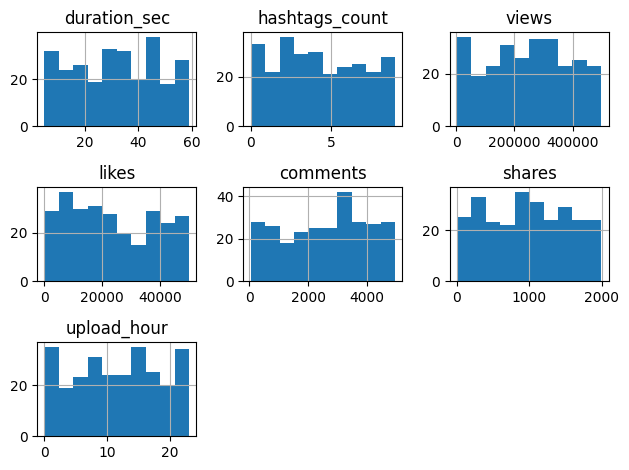

In [113]:
df_train.hist()
plt.tight_layout()
plt.show()

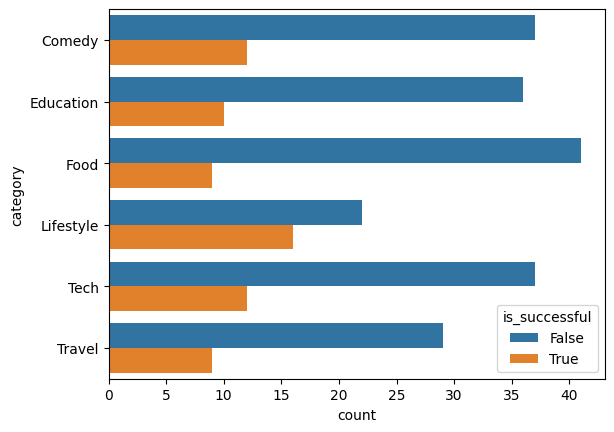

In [114]:
sns.countplot(data=df_train, y='category', hue='is_successful')
plt.show()

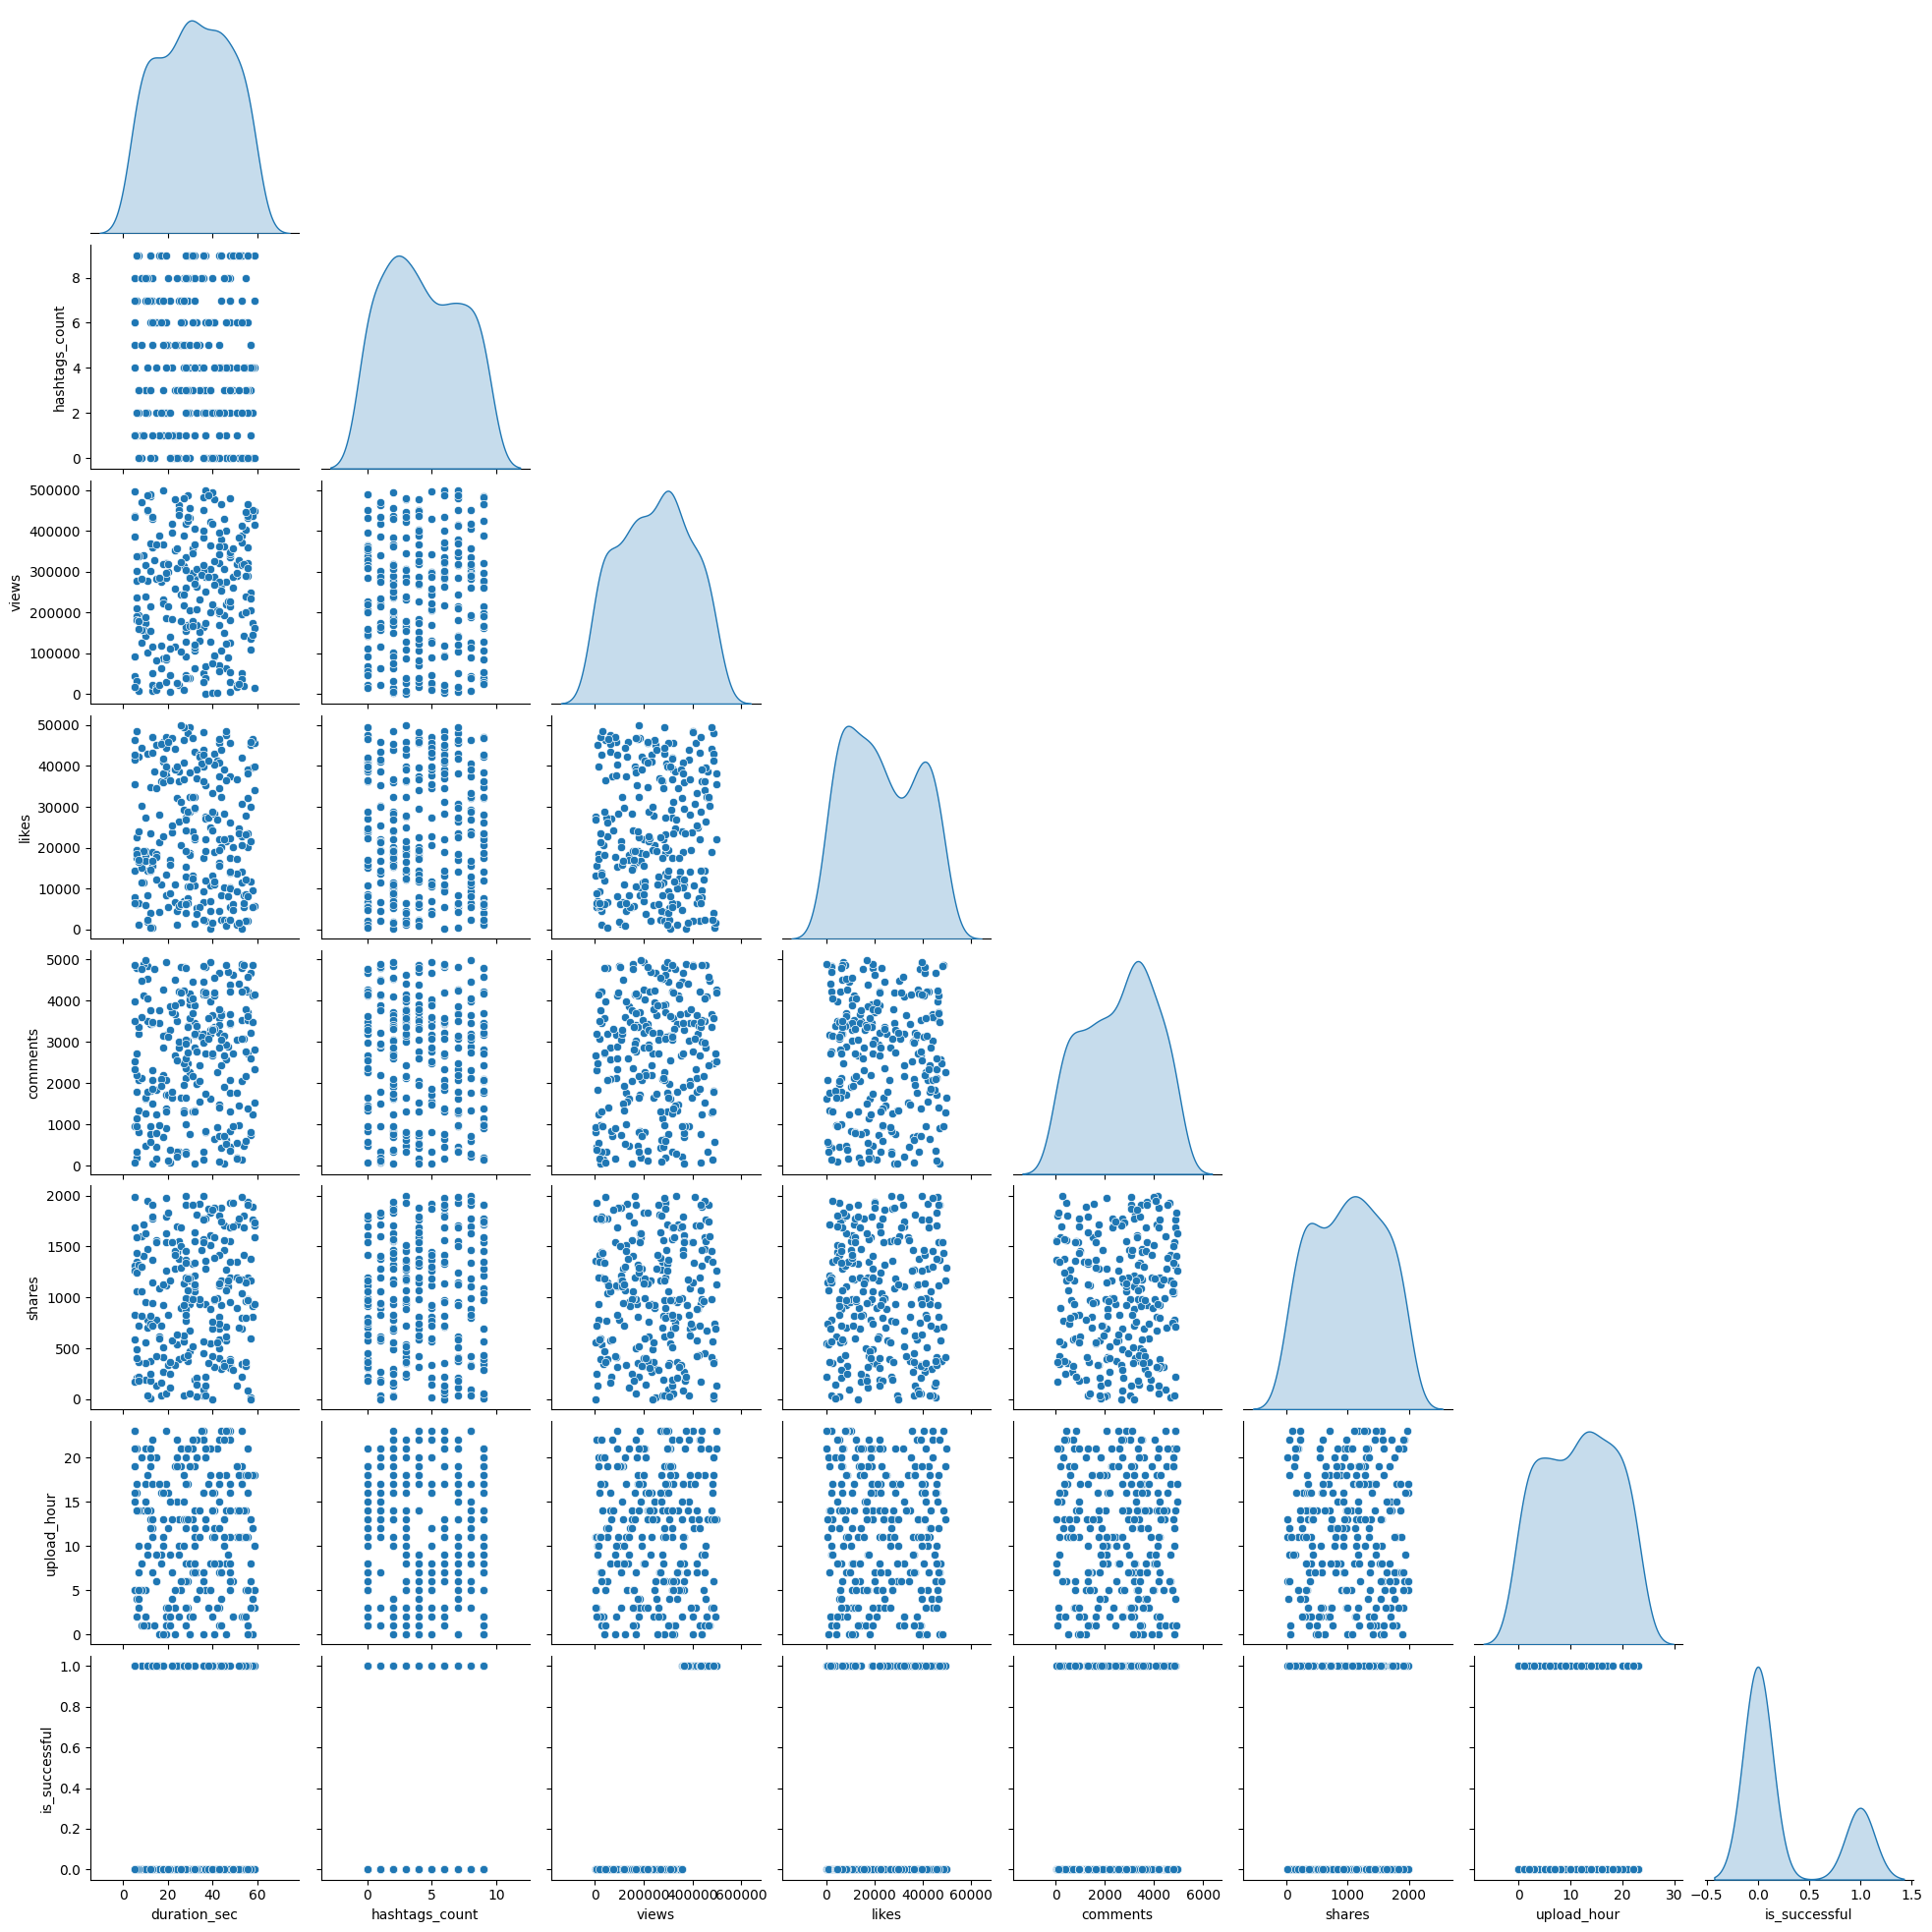

In [115]:
sns.pairplot(df_train, diag_kind='kde', corner=True)
plt.show()

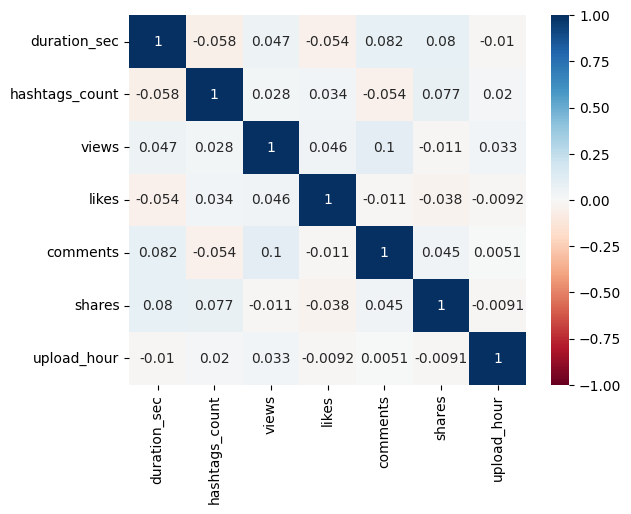

In [116]:
sns.heatmap(data=df_train.select_dtypes('number').corr(), vmin=-1, cmap='RdBu', annot=True)
plt.show()

In [117]:
#ML model
X_train = df_train.drop(columns=['is_successful','likes','comments','shares','views'])
y_train = df_train['is_successful']

X_test = df_test.drop(columns=['is_successful','likes','comments','shares','views'])
y_test = df_test['is_successful']

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob)
    }



In [118]:

encoder = LabelEncoder()
cat_cols = X_train.select_dtypes('category').columns

for col in cat_cols:
    X_train[col] = encoder.fit_transform(X_train[col])
    X_test[col] = encoder.transform(X_test[col])


In [107]:

gb = GradientBoostingClassifier(random_state=2025)
gb.fit(X_train,y_train)


,"loss loss: {'log_loss', 'exponential'}, default='log_loss'The loss function to be optimized. 'log_loss' refers to binomial andmultinomial deviance, the same as used in logistic regression.It is a good choice for classification with probabilistic outputs.For loss 'exponential', gradient boosting recovers the AdaBoost algorithm.",'log_loss'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.For an example of the effects of this parameter and its interaction with``subsample``, see:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_regularization.py`.",0.1
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",100
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are'friedman_mse' for the mean squared error with improvement score byFriedman, 'squared_error' for mean squared error. The default value of'friedman_mse' is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, 

In [119]:
y_prob = gb.predict_proba(X_test)[:, 1]

# Predicción con threshold 0.5
y_pred_default = (y_prob >= 0.5).astype(int)

metrics_default = {
    "Accuracy": accuracy_score(y_test, y_pred_default),
    "Precision": precision_score(y_test, y_pred_default, zero_division=0),
    "Recall": recall_score(y_test, y_pred_default),
    "F1-score": f1_score(y_test, y_pred_default),
    "ROC-AUC": roc_auc_score(y_test, y_prob)
}

metrics_default

{'Accuracy': 0.9333333333333333,
 'Precision': 1.0,
 'Recall': 0.7142857142857143,
 'F1-score': 0.8333333333333334,
 'ROC-AUC': 1.0}

In [120]:
joblib.dump(gb, "model_gb.pkl")

['model_gb.pkl']